<a href="https://colab.research.google.com/github/lustraka/Data_Analysis_Workouts/blob/main/Communicate_Data_Findings/Time_Series_Store_Sales_WorkOut.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Store Sales - Time Series Forecasting
**Use machine learning to predict grocery sales**

[Kaggle Competition](https://www.kaggle.com/c/store-sales-time-series-forecasting/overview)

The basic object of forecasting is the **time series**, which is a set of observations recorded over time. In forecasting applications, the observations are typically recorded with a regular frequency, like daily or monthly.

In [1]:
import os
# Set the environment variables
os.environ['KAGGLE_USERNAME'] = "lubomrstraka"
os.environ['KAGGLE_KEY'] = "c7347462ef834e6645ce238c2f2fa561"

# Upgrade kaggle library
os.system("pip install kaggle --upgrade --quiet")

# Download datasets
os.system("kaggle competitions download -c store-sales-time-series-forecasting --quiet")

0

In [2]:
import zipfile
# Extract train.csv
with zipfile.ZipFile('train.csv.zip') as archive:
  archive.extractall()

In [3]:
# Import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.formula.api as smf

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
dtype = {'store_nbr': 'category', 'family': 'category', 'sales': 'float32', 'onpromotion': 'uint64'}
store_sales = pd.read_csv('train.csv', index_col=0, dtype=dtype, parse_dates=['date'], infer_datetime_format=True)
store_sales.sample(5)

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,date,store_nbr,family,sales,onpromotion
id,,,,,
2284868,2016-07-09,19,HARDWARE,3.000000,2
793976,2014-03-23,36,PREPARED FOODS,57.814999,0
1460375,2015-04-02,34,PET SUPPLIES,0.000000,0
1980373,2016-01-20,25,EGGS,85.000000,19
1046504,2014-08-12,22,DAIRY,0.000000,0


**A Data Set Description**

A `store_sales` data set contains data for thousands of product families sold at Corporación Favorita, a large Ecuadorian-based grocery retailer. The data set includes dates, store and product information, whether that item was being promoted, as well as the sales numbers. Additional files include supplementary information that may be useful in extracting knowledge and building forecasting models.

| # | Variable | Non-Null | Nunique | Dtype | Notes |
|---|----------|----------|---------|-------|-------|
| 0 | id | 3000888 | 3000888 | int64 | Converted to an index. | 
| 1 | date | 3000888 | 1684 | datetime64[ns] | Observations from 2013-01-01 to 2017-08-15. |
| 2 | store_nbr | 3000888 | 54 | category | Identifies the store at which the products are sold. |
| 3 | family | 3000888 | 33 | category | Identifies the type of product sold. |
| 4 | sales | 3000888 | 379610 | float32 | Gives the total sales for a product family at a particular store at a given date. <br/>Fractional values are possible since products can be sold in fractional units <br/>(1.5 kg of cheese, for instance, as opposed to 1 bag of chips). |
| 5 | onpromotion | 3000888 | 991 | uint64 | Gives the total number of items in a product family that were being promoted at a store at a given date.|

Memory usage of `store_sales`:
- 137.4+ MB before applying the dict *dtype*
- 85.9+ MB after applying the dict *dtype*

In [5]:
store_sales.date.min(), store_sales.date.max()

(Timestamp('2013-01-01 00:00:00'), Timestamp('2017-08-15 00:00:00'))

## Average Sales
The *average_sales* variable is derived from the `store_sales` dataframe and identifies the average sales each day.

In [6]:
average_sales = store_sales.groupby('date').mean()['sales'].to_frame()
average_sales.head()

,sales
date,
2013-01-01,1.409438
2013-01-02,278.390808
2013-01-03,202.840195
2013-01-04,198.911148
2013-01-05,267.873230


### Time-Step Features
Time-step features are features we can derive directly from the time index. The most basic time-step feature is the **time dummy**, which counts off time steps in the series from beginning to end.

In [7]:
# Create a time dummy
df = average_sales.copy()
df['time'] = np.arange(len(df.index))

A **simple linear regression** model estimates coefficients of a least squares line:
$$\hat{y} = \hat{\beta}_0 + \hat{\beta}_1 x,$$
in our case
$$\hat{\text{sales}} = \hat{\text{coef}}_{Intercept} + \hat{\text{coef}}_{time} \times \text{time}:$$

In [8]:
lm = smf.ols('sales ~ time', data=df).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.516
Model:                            OLS   Adj. R-squared:                  0.516
Method:                 Least Squares   F-statistic:                     1794.
Date:                Wed, 20 Oct 2021   Prob (F-statistic):          1.87e-267
Time:                        09:10:44   Log-Likelihood:                -9994.5
No. Observations:                1684   AIC:                         1.999e+04
Df Residuals:                    1682   BIC:                         2.000e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    194.2328      4.459     43.562      0.0

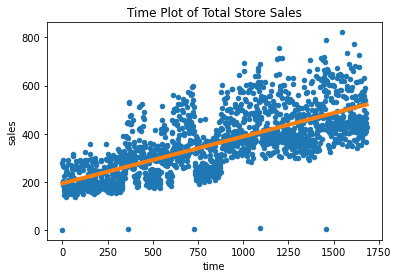

In [9]:
def feature_sales_plot(df, lm, feature):
  """Plots a scatter plot of `feature` versus `sales` with a regression line from `lm`."""
  df.plot(kind='scatter', x=feature, y='sales')
  feat_min_max = [df[feature].min(), df[feature].max()]
  plt.plot(feat_min_max, 
          [lm.params['Intercept'] + lm.params[feature] * x for x in feat_min_max],
          color='tab:orange', lw=4)
  plt.title(f'{feature.capitalize()} Plot of Total Store Sales')
  plt.show

feature_sales_plot(df, lm, 'time')

Time-step features let us model **time dependence**. A series is time dependent if its values can be predicted from the time they occured. The linear regression of *sales* on *time* shows a relationship with estimation of $\hat{\text{coef}}_{time} = 0.1943$ and true value of the slope $\text{coef}_{time}$ being with $95\%$ confidence in the interval $[0.185, 0.203]$, so we can expect the sales being in average $0.1943$ unit higher every next day.

### Lag Features
To make a **lag feature** we shift the observations of the target series so that they appear to have occured later in time. Here we've created a 1-step lag feature, though shifting by multiple steps is possible too.

In [10]:
# Create a lag feature from the response variable 'sales'
df = average_sales.copy()
df['lag_1'] = df.sales.shift(1)
df.dropna(inplace=True)
df.head()

,sales,lag_1
date,,
2013-01-02,278.390808,1.409438
2013-01-03,202.840195,278.390808
2013-01-04,198.911148,202.840195
2013-01-05,267.873230,198.911148
2013-01-06,291.636017,267.873230


Simple linear regression with a lag feature produces the model:
$$\text{sales} = \hat{\text{coef}}_{\text{Intercept}} + \hat{\text{coef}}_{\text{lag_1}} \times \text{lag_1}:$$

In [11]:
lm = smf.ols('sales ~ lag_1', data=df).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.588
Model:                            OLS   Adj. R-squared:                  0.588
Method:                 Least Squares   F-statistic:                     2400.
Date:                Wed, 20 Oct 2021   Prob (F-statistic):               0.00
Time:                        09:10:45   Log-Likelihood:                -9849.9
No. Observations:                1683   AIC:                         1.970e+04
Df Residuals:                    1681   BIC:                         1.971e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     84.2231      5.954     14.146      0.0

Lag features let us fit curves to *lag plots* where each observation in a series is plotted against the previous observation:

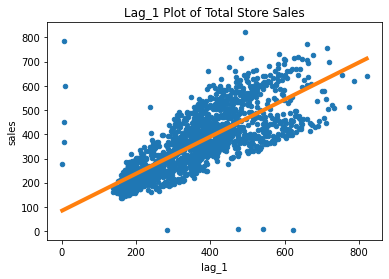

In [12]:
feature_sales_plot(df, lm, 'lag_1')

We can expect from the lag plot that a unit sale increase one day will be followed with $\hat{\text{coef}}_{\text{lag_1}} = 0.7653$ unit higher increase the next day in average. The true value of the linear regression line's slope is with $95\%$ confidence in the interval $[0.735, 0.796]$